# Simulation of the wireless communication system project in Signals and transforms

In [69]:
import argparse
import numpy as np
from scipy import signal
import sounddevice as sd
import matplotlib.pyplot as plt
import wcslib as wcs

## Parameters

In [70]:
# TODO: Add your parameters here. You might need to add other parameters as well.
channel_id = 17
Tb = 0.01
fs = 4400
dt = 1/22050
Ac = 1
fc = 4400
b_r = 1 / Tb # changed from bs to b_r
wc = 27646    # rad/s
alpha = 2 * np.pi * 200
# Ar = |H(w)| * Ac
tr = 1
phi = -wc*tr

# Message to be transmitted
data = "Hello World!"

## Filter design

In [71]:
# TODO: Design the filters

## Transmitter

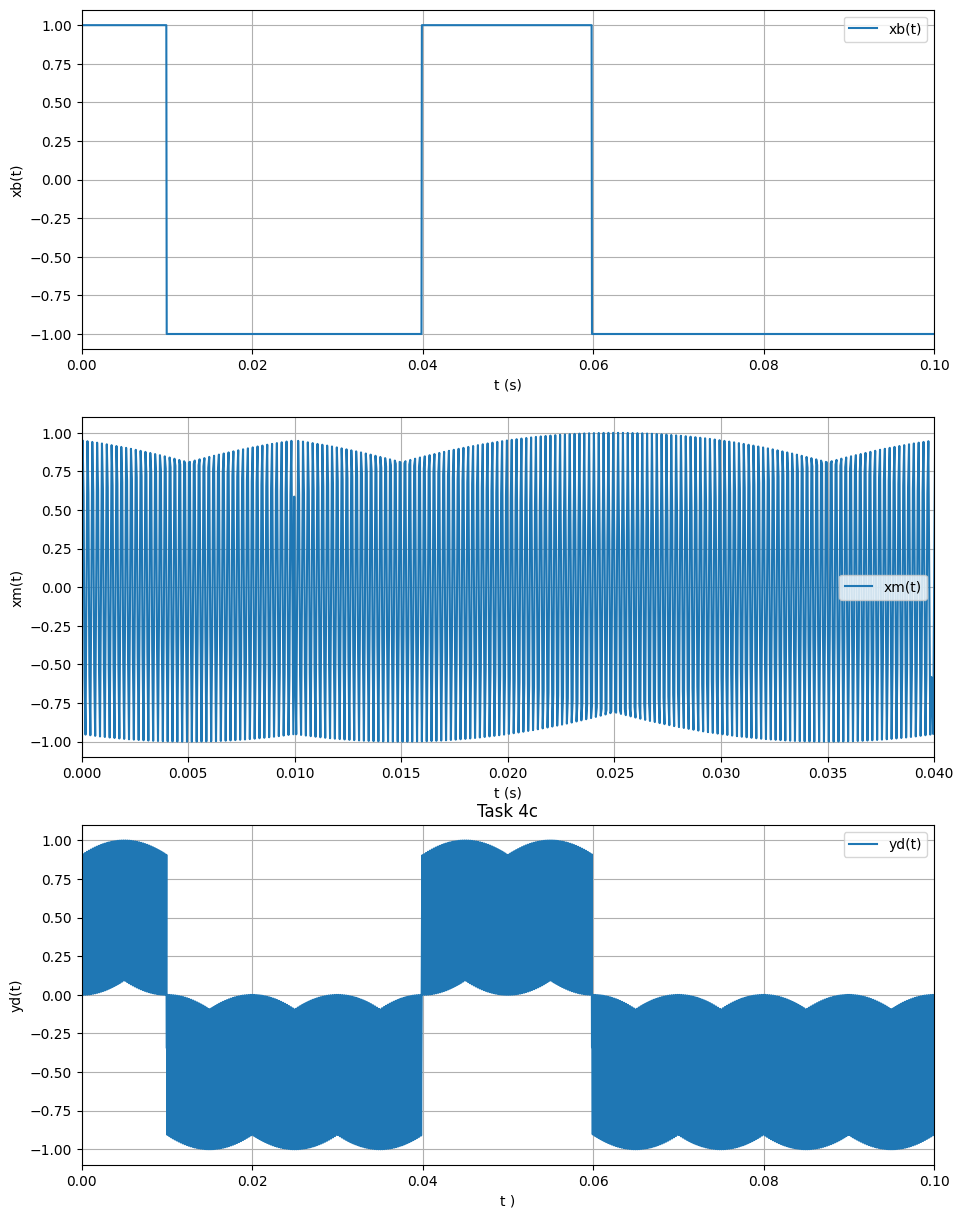

In [77]:
data = '010010000110100100100001'
# data = '1010101010'
# Convert string to bit sequence
bs = wcs.encode_string(data)
    
# Encode baseband signal
xb = wcs.encode_baseband_signal(bs, Tb, 1/dt)

# TODO: Put your transmitter code here (modulation, filtering, etc.)
t = np.arange(0, xb.shape[0]) * dt  
t1 = 10*Tb
# plot = int(np.ceil(t1/dt))

# Ensure the signal is mono, then play through#  speakers
xc = Ac * np.sin(wc * t)                             # Task 4b)
xm = xb * xc
xt = xm
yd = xm * np.sin(wc * t)

xt = np.stack((xt, np.zeros(xt.shape)), axis=1)
sd.play(xt, 1/dt,blocking=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11,15))

#### TASK 4A #### #
plt.title("Task 4a")
ax1.plot(t, xb, label="xb(t)")
ax1.legend()
ax1.set_xlabel("t (s)")
ax1.set_ylabel("xb(t)")
ax1.set_xlim(0, t1)
ax1.grid()

#### TASK 4####
plt.title("Task 4b")
ax2.plot(t, xm, label="xm(t)")
ax2.legend()
ax2.set_xlabel("t (s)")
ax2.set_ylabel("xm(t)")
ax2.set_xlim(0, 4*Tb)
ax2.grid()

#### TASK 4C ####
plt.title("Task 4c")
ax3.plot(t, yd, label="yd(t)")
ax3.legend()
ax3.set_xlabel("t )")
ax3.set_ylabel("yd(t)")
ax3.set_xlim(0, t1) 
ax3.grid()
fig.savefig('lab1_task4.png')

## Simulate transmission

In [73]:
# yr = wcs.simulate_channel(xt, fs, channel_id)

## Receiver

Received: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

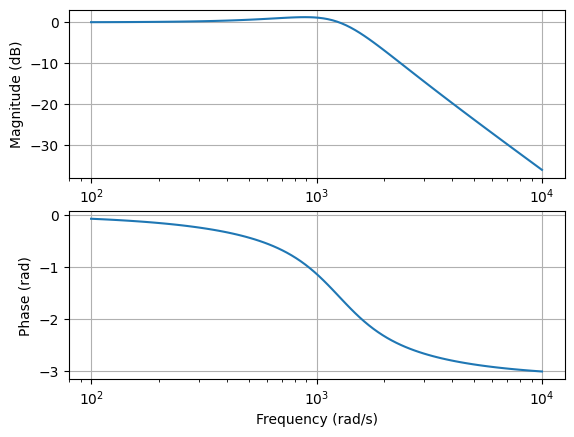

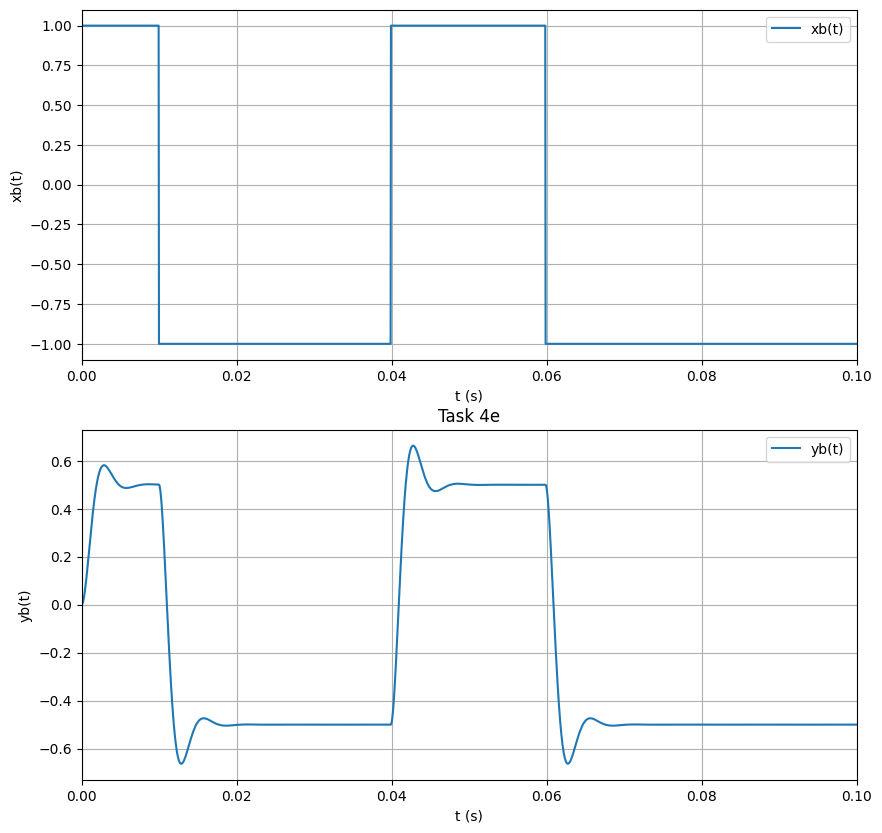

In [ ]:
# TODO: Put your receiver code (filtering, demodulation, etc.) here
# TODO: Implement demodulation, etc. here

num = [alpha**signal.TransferFunction(num, den)

w, mag, phase = H.bode()
# mag_log = 20*np.log10(mag) # dB
phase_rad = (phase * np.pi) / 180

#### Task 4d) ####
fig, ax4 = plt.subplots(2, 1)
ax4[0].semilogx(w, mag)
ax4[0].set_ylabel("Magnitude (dB)")
ax4[0].grid()

ax4[1].semilogx(w, phase_rad)
ax4[1].set_ylabel("Phase (rad)")
ax4[1].set_xlabel("Frequency (rad/s)")
ax4[1].grid()
fig.savefig('lab1_task4d.png')
# plt.show()

#### Task 4e) ####
__, yb, __ = signal.lsim(H, yd, t)

fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
plt.title("Task 4e")
ax1.plot(t, xb, label="xb(t)")
ax1.legend()
ax1.set_xlabel("t (s)")
ax1.set_ylabel("xb(t)")
ax1.set_xlim(0, t1)
ax1.grid()

ax2.plot(t, yb, label="yb(t)")
ax2.legend()
ax2.set_xlabel("t (s)")
ax2.set_ylabel("yb(t)")
ax2.set_xlim(0, t1)
ax2.grid()

fig2.savefig("lab1_task4e")

# Calculate complex baseband signal
# yb = ybi + 1j*ybq

# Symbol decoding
br = wcs.decode_baseband_signal(yb, Tb, fs)
print(f'Received: {br} (no of bits: {len(br)}).')
# data_rx = wcs.decode_string(br)
# print('Received: ' + data_rx)